In [1]:
import pandas as pd
import numpy as np

/var/folders/zp/c97k147160ddnklbfc2rk3hr0000gn/T/ipykernel_10615/2162656668.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_pickle('data/SBAmodel.pickle')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.head(1)

,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv
0,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,45,1997-02-28,1997,84,4,1,0,0,1,0,0,0,1,60000.0


## Encodage de BankState

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df.BankState = le.fit_transform(df.loc[:,['BankState']])
df.BankState = df.BankState.astype('category')

# Split

In [3]:
from feature_engine.selection import DropFeatures
from sklearn.model_selection import train_test_split

X = df.drop(columns=['MIS_Status'])
y = df.MIS_Status

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=69
)

X_train.head(1)

,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,GrAppv
217398,"TANEYCOMO PIZZA,INC.",HOLLISTER,MO,65672,LIBERTY BANK,MO,72,2006-11-20,2007,110,1,1,0,0,64900,2,0,0,662000.0


In [18]:
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.pipeline import FunctionTransformer, make_pipeline
from xgboost import XGBClassifier

set_config(transform_output = "pandas")

drop = DropFeatures(features_to_drop=['Name', 'City', 'Bank', 'State', 'NewExist', 'LowDoc'])
transformers = ColumnTransformer(
    transformers = [
        ('date', FunctionTransformer(lambda x: x.astype(int)), ['ApprovalDate'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False)

bankstate_transformer = ColumnTransformer(
    transformers = [
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['BankState'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False)

scaler = StandardScaler()
estimator = XGBClassifier()
feature_selection = make_pipeline(
        VarianceThreshold(threshold=0.5)
)

pipe = make_pipeline(
            drop,
            transformers,
            bankstate_transformer,
            #feature_selection,
            scaler,
            estimator)
d = pipe[:-1].fit_transform(X_train, y_train)
display(d.head(1))
print(d.shape)

,BankState_AK,BankState_AL,BankState_AN,BankState_AR,BankState_AZ,BankState_CA,BankState_CO,BankState_CT,BankState_DC,BankState_DE,BankState_FL,BankState_GA,BankState_GU,BankState_HI,BankState_IA,BankState_ID,BankState_IL,BankState_IN,BankState_KS,BankState_KY,BankState_LA,BankState_MA,BankState_MD,BankState_ME,BankState_MI,BankState_MN,BankState_MO,BankState_MS,BankState_MT,BankState_NC,BankState_ND,BankState_NE,BankState_NH,BankState_NJ,BankState_NM,BankState_NV,BankState_NY,BankState_OH,BankState_OK,BankState_OR,BankState_PA,BankState_PR,BankState_RI,BankState_SC,BankState_SD,BankState_TN,BankState_TX,BankState_UT,BankState_VA,BankState_VI,BankState_VT,BankState_WA,BankState_WI,BankState_WV,BankState_WY,ApprovalDate,Zip,NAICS,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,GrAppv
217398,-0.039754,-0.117055,-0.001179,-0.083933,-0.066013,-0.389735,-0.108902,-0.105983,-0.066668,-0.167153,-0.125249,-0.124422,-0.002358,-0.057555,-0.105371,-0.070534,-0.281212,-0.092488,-0.099907,-0.070085,-0.075247,-0.125763,-0.089277,-0.064335,-0.091094,-0.150866,7.699404,-0.081841,-0.0939,-0.31167,-0.075471,-0.077312,-0.087367,-0.103019,-0.070215,-0.070135,-0.215191,-0.263765,-0.090401,-0.112935,-0.139453,-0.013078,-0.230871,-0.091736,-0.245606,-0.079058,-0.237411,-0.147112,-0.182557,-0.001179,-0.073029,-0.109722,-0.131957,-0.047554,-0.049285,0.926727,0.380721,1.233243,0.990324,-0.009636,-0.137207,-0.035515,-0.045553,4.883278,1.920698,-0.692632,1.658432


(719331, 67)


In [19]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('dropfeatures',
                 DropFeatures(features_to_drop=['Name', 'City', 'Bank', 'State',
                                                'NewExist', 'LowDoc'])),
                ('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date',
                                                  FunctionTransformer(func=<function <lambda> at 0x2c22444a0>),
                                                  ['ApprovalDate'])],
                                   verbose_feature_names_out=False)),
                ('columntransformer-2',
                 ColumnTransfor...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

              precision    recall  f1-score   support

           0       0.88      0.83      0.85     31512
           1       0.96      0.98      0.97    148321

    accuracy                           0.95    179833
   macro avg       0.92      0.90      0.91    179833
weighted avg       0.95      0.95      0.95    179833



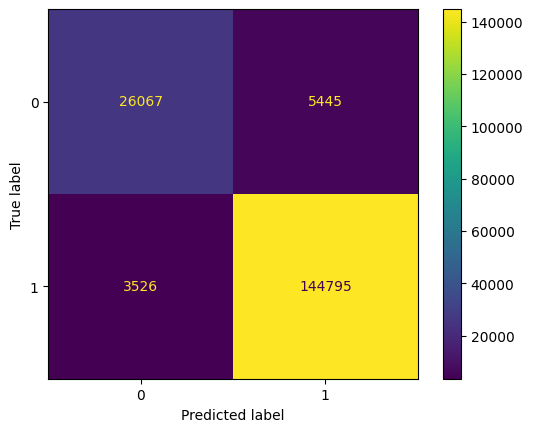

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

y_pred = pipe.predict(X_test)
classification = classification_report(y_test, y_pred)
print(classification)

cf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cf_matrix).plot()

In [97]:
X_train_transf = pipe[:-1].fit_transform(X_train, y_train)
feat_labels = X_train_transf.columns

f = pd.DataFrame({'features': np.array(list(feat_labels)), 'score': pipe.named_steps['randomforestclassifier'].feature_importances_})
f = f.round({'score': 5})
f.sort_values(by=['score'], ascending=False, inplace=True)
f

,features,score
59,Term,0.42940
58,ApprovalFY,0.16256
55,ApprovalDate,0.15270
63,FranchiseCode,0.05842
66,GrAppv,0.04485
62,RetainedJob,0.04189
64,UrbanRural,0.03795
60,NoEmp,0.01262
48,BankState_VA,0.00875
29,BankState_NC,0.00862


In [101]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, validation_scores = learning_curve(
    estimator = pipe.named_steps['randomforestclassifier'],
    X = X_train_transf,
    y = y_train,
    train_sizes = np.linspace(0.00001, 1, 10),
    cv = 3,
    scoring = 'accuracy',
    n_jobs=-1
)

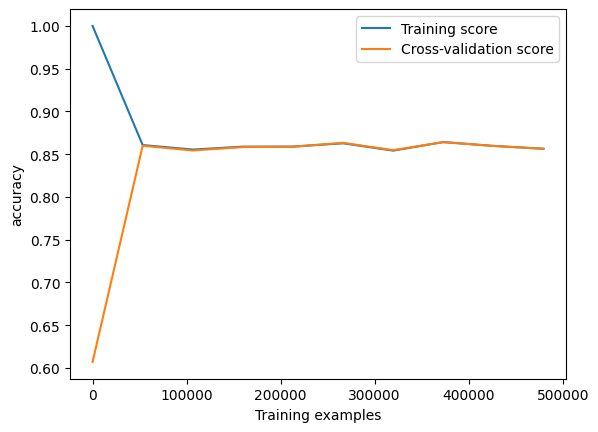

In [102]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(validation_scores, axis=1)
test_std = np.std(validation_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("accuracy")
plt.legend()

In [103]:
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = pipe.named_steps['randomforestclassifier'],
    X = X_train_transf,
    y = y_train,
    train_sizes = np.linspace(0.00001, 1, 10),
    cv = 3,
    scoring = 'f1_macro',
    n_jobs=-1
)

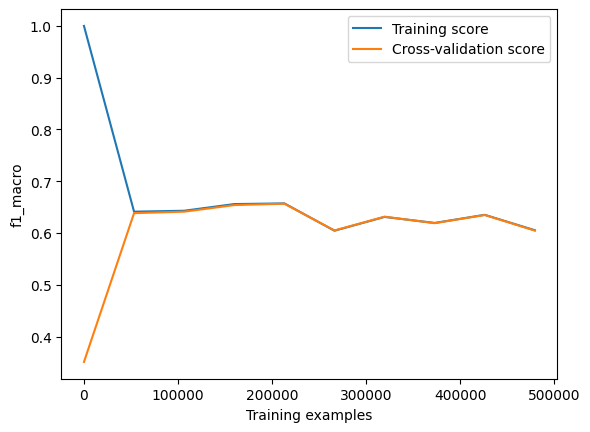

In [104]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(validation_scores, axis=1)
test_std = np.std(validation_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("f1_macro")
plt.legend()